In this kernel we will go through a sentiment analysis on Reddit dataset using LSTM. This notebook is been written by combing through Kaggle and many other websites that provide sample tutorials on how to do sentimental analysis.

We focus only on the sentiment of body of the comment.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn

import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import nltk
nltk.download(["names","stopwords","state_union","twitter_samples","movie_reviews","averaged_perceptron_tagger","vader_lexicon","punkt"])
from nltk.sentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package state_union to /root/nltk_data...
[nltk_data]   Package state_union is already up-to-date!
[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [3]:
base_csv = '/content/reddit_wsb.csv'
df = pd.read_csv(base_csv)
df.drop(columns=['id', 'url', 'created','score','comms_num'], inplace=True)
df.head()

,title,body,timestamp
0,"It's not about the money, it's about sending a...",NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,NaN,2021-01-28 21:32:10
2,Exit the system,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",NaN,2021-01-28 21:26:56


Let's label the data with the sentiment and use nltk sentimental analysis for getting that information

In [4]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

sid                        = SentimentIntensityAnalyzer()
df['main_sentiments']      = df['body'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',str(x).lower()))))
df['Positive Sentiment']   = df['main_sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
df['Neutral Sentiment']    = df['main_sentiments'].apply(lambda x: x['neu']+1*(10**-6))
df['Negative Sentiment']   = df['main_sentiments'].apply(lambda x: x['neg']+1*(10**-6))
df['sents']                = df[['Positive Sentiment', 'Neutral Sentiment', 'Negative Sentiment']].idxmax(axis=1)
print(df['main_sentiments'].head())

df['length'] = df['body'].apply(lambda s: len(str(s).split()))
df.sort_values(by=['length'], ascending=False, inplace=True)
df=df[df.length >1]
df=df.reset_index()
df.head()

0    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
2    {'neg': 0.07, 'neu': 0.87, 'pos': 0.059, 'comp...
3    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
Name: main_sentiments, dtype: object


,index,title,body,timestamp,main_sentiments,Positive Sentiment,Neutral Sentiment,Negative Sentiment,sents,length
0,17232,Gamestop Big Picture: The Short Singularity Pt...,"Yes, as you read, cross post from r/boringpeo...",2021-01-30 02:40:55,"{'neg': 0.108, 'neu': 0.753, 'pos': 0.14, 'com...",0.140001,0.753001,0.108001,Neutral Sentiment,6140
1,37146,Dark DD and possible profit in the face of ano...,# Preface\n\nI want to start by saying this h...,2021-03-02 10:36:36,"{'neg': 0.129, 'neu': 0.788, 'pos': 0.083, 'co...",0.083001,0.788001,0.129001,Neutral Sentiment,5764
2,36697,History of short squeezes and corners,Very long post summarising hundreds of years w...,2021-02-27 22:41:29,"{'neg': 0.089, 'neu': 0.806, 'pos': 0.105, 'co...",0.105001,0.806001,0.089001,Neutral Sentiment,5762
3,34748,The silver short squeeze is glaringly obvious ...,"First off, if you are long GME this is not a p...",2021-02-20 14:42:16,"{'neg': 0.057, 'neu': 0.855, 'pos': 0.088, 'co...",0.088001,0.855001,0.057001,Neutral Sentiment,5127
4,33429,The Commodity Super-cycle trade: A macro DD wi...,“Commodities? What the hell is that?” asks the...,2021-02-16 11:25:01,"{'neg': 0.065, 'neu': 0.811, 'pos': 0.125, 'co...",0.125001,0.811001,0.065001,Neutral Sentiment,5071


### Splitting to train and test data

We will split data to train and test initially.We can save 10% of data as test data. Use the rest 90% for training and validation of the model.


In [5]:
X,y = df['body'].values,df['sents'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of xtrain data is {x_train.shape}')
print(f'shape of ytrain data is {y_train.shape}')
print(f'shape of test data is {x_test.shape}')


shape of xtrain data is (14710,)
shape of ytrain data is (14710,)
shape of test data is (4904,)


### Analysing sentiment

In [ ]:
print(X[10])
print(y[197:])


### Tockenization

In [8]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []
    encoded_test =[]
    encoded_train = []
    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in str(sent).lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    for label in y_train:
      if label == 'Positive Sentiment':
        encoded_train.append(1)
      elif label == 'Negative Sentiment':
        encoded_train.append(2)
      else:
        encoded_train.append(0)
    for label in y_val:
      if label == 'Positive Sentiment':
        encoded_test.append(1)
      elif label == 'Negative Sentiment':
        encoded_test.append(2)
      else:
        encoded_test.append(0)    
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


In [9]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [10]:
#tokenizer = get_tokenizer('basic_english')
print(vocab)
print(f'Length of vocabulary is {len(vocab)}')
print(x_train[:10])
print(y_train[:10000])
print(x_test[:10])
print(y_test[:90])

{'gme': 1, 'stock': 2, 'shares': 3, 'like': 4, 'market': 5, 'im': 6, 'price': 7, 'short': 8, 'buy': 9, 'dont': 10, 'people': 11, 'money': 12, 'get': 13, 'know': 14, 'us': 15, 'would': 16, 'going': 17, 'one': 18, 'time': 19, 'xb': 20, 'make': 21, 'hold': 22, 'even': 23, 'sell': 24, 'see': 25, 'also': 26, 'think': 27, 'go': 28, 'company': 29, 'still': 30, 'stocks': 31, 'back': 32, 'could': 33, 'new': 34, 'robinhood': 35, 'want': 36, 'share': 37, 'fucking': 38, 'trading': 39, 'financial': 40, 'squeeze': 41, 'right': 42, 'hedge': 43, 'last': 44, 'amc': 45, 'good': 46, 'much': 47, 'buying': 48, 'take': 49, 'way': 50, 'day': 51, 'funds': 52, 'need': 53, 'long': 54, 'well': 55, 'fuck': 56, 'big': 57, 'many': 58, 'shorts': 59, 'year': 60, 'week': 61, 'holding': 62, 'lot': 63, 'interest': 64, 'thats': 65, 'positions': 66, 'cant': 67, 'first': 68, 'next': 69, 'million': 70, 'edit': 71, 'really': 72, 'options': 73, 'may': 74, 'today': 75, 'shit': 76, 'post': 77, 'got': 78, 'since': 79, 'retail': 

### Analysing review length

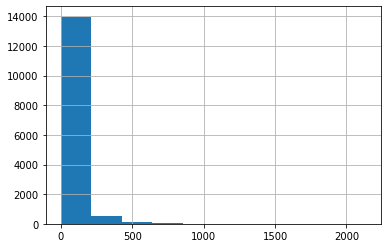

count    14710.000000
mean        54.198368
std         96.838595
min          0.000000
25%          7.000000
50%         21.000000
75%         60.000000
max       2132.000000
dtype: float64

In [11]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

Observations : <br>a) Mean body length = around 54.<br> b) minimum length of body is 0.<br>c)There are quite a few body comments that are extremely long. We still include them in the dataset.

### Padding

Now we will pad each of the sequence to max length 

In [12]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [13]:
#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = padding_(x_train,100)
x_test_pad = padding_(x_test,100)


### Batching and loading as tensor

In [14]:
print(y_train.shape)
print(x_train_pad.shape)
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 2

print(y_train.shape)
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

(14710,)
(14710, 100)
(14710,)


In [15]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([2, 100])
Sample input: 
 tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          46, 378, 418,  78,  39,  44,  60,  92,  31,  84,  78,   2, 531,  26,
         557, 557,  10,  47, 339,  16, 241, 397, 110,   1,  10,  47, 397, 129,
          10,  27,   3,  47, 558, 164,  16, 558, 863,   1,  16,  73, 905, 109,
          95, 556],
        [405, 570, 119,  91,  78,  24,  99, 494, 337, 138, 801,  96,  73, 869,
         847,  30,  27,  46, 125, 774,  42, 899, 211,  97, 776,   4,  27, 810,
          76,  63,  11,  10,  72, 673,  18,  20, 194,  35, 761, 797, 534, 160,
          37,   2, 341,   6, 134,  96,   6,  26,  63,   3,  13,   1, 215,  94,
          82,  58, 543, 943, 175,  28, 394,  19,  23, 

### Model

In [24]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,num_layers=no_layers, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
           
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

              

In [25]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256

model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)
#model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)


SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


### Training

In [26]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()


In [27]:
clip = 5
epochs = 5 
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), '/content/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')
    

Epoch 1
train_loss : 0.11024288155192724 val_loss : 0.08670806205872489
train_accuracy : 98.23929299796058 val_accuracy : 98.3278955954323
Validation loss decreased (inf --> 0.086708).  Saving model ...
Epoch 2
train_loss : 0.0668403299537914 val_loss : 0.08307484405987507
train_accuracy : 97.99456152277362 val_accuracy : 97.14518760195759
Validation loss decreased (0.086708 --> 0.083075).  Saving model ...
Epoch 3
train_loss : 0.051716582726923706 val_loss : 0.07220569805131119
train_accuracy : 98.03535010197145 val_accuracy : 98.12398042414355
Validation loss decreased (0.083075 --> 0.072206).  Saving model ...
Epoch 4
train_loss : -0.024029111007393356 val_loss : 0.042927323408938754
train_accuracy : 98.04214819850442 val_accuracy : 97.55301794453507
Validation loss decreased (0.072206 --> 0.042927).  Saving model ...
Epoch 5
train_loss : -0.203311756803179 val_loss : 0.0814787636272666
train_accuracy : 98.17131203263087 val_accuracy : 97.14518760195759


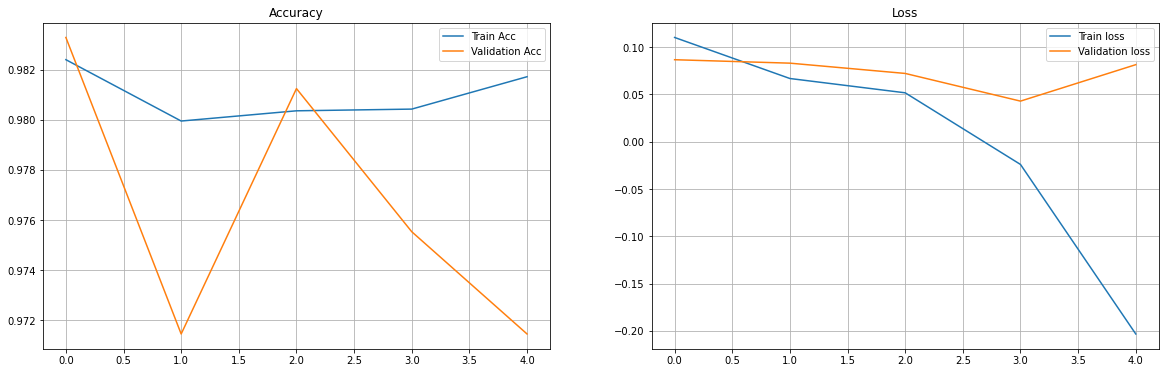

In [28]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [ ]:
class_names=['Positive Sentiment']
print(classification_report(y_true, y_pred, target_names=class_names))